<h1>Part 1: Importing Libraries</h1>

In [1]:
import pandas as pd
import numpy as np

<h1>Part 2: Loading Datasets</h1>

In [2]:
trainDataBinary = pd.read_csv('data\TrainingDataBinary.csv', sep=',')
testDataBinary = pd.read_csv('data\TestingDataBinary.csv', sep=',')

# to check whether data was correctly loaded
print("Part A Training Data")
trainDataBinary.info() 
print("\nPart A Testing Data")
testDataBinary.info()

Part A Training Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Columns: 129 entries, R1-PA1:VH to marker
dtypes: float64(112), int64(17)
memory usage: 5.9 MB

Part A Testing Data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 128 entries, R1-PA1:VH to snort_log4
dtypes: float64(112), int64(16)
memory usage: 100.1 KB


<h1>Part 3: Data Preprocessing</h1>

The hold-out method was used to separate the labelled data instances into a training set and a test set. A 80-20 split was used instead of a 70-30 split. The 80-20 split gives a larger training set for the model, which can potentially improve classification performance.

The provided training data has a balanced distribution of the two labels. Therefore, the training set and test set will also has the same distribution. 

In [3]:
from sklearn.model_selection import train_test_split

# getting the labels
Y = trainDataBinary['marker']
# removing the labels in the dataset
X = trainDataBinary.drop('marker',axis=1)

# splitting the training dataset into training set and test set
# 80-20 split (larger training set to improve model performance)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=58, stratify=Y)

In [4]:
# ensuring test set has 50-50 split of labels
Y_test.value_counts()

1    600
0    600
Name: marker, dtype: int64

MinMax Scaling to attempt to speed up CV.

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
testDataBinary = scaler.transform(testDataBinary)

<h1>Part 4: Feature Selection</h1>

None. Raw features were used to train the model.

<h1>Part 5: Model Selection (Logistic Regression)</h1>

In [6]:
from sklearn.svm import LinearSVC
clf = LinearSVC()

<h1>Part 6: Hyperparameter Tuning</h1>

Optimal value of the hyperparameter C was found using GridSearchCV in the range of 0 to 10000 (50 points on a log scale).

In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "penalty": ['l1', 'l2'],
    "loss": ['hinge', 'squared_hinge'],
}

bestSVC = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, verbose=4)
bestSVC.fit(X_train, Y_train)
print("Best parameter (CV score=%0.3f):" % bestSVC.best_score_)
print(bestSVC.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\yingz\miniconda3\envs\cybersec\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\yingz\miniconda3\envs\cybersec\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\yingz\miniconda3\envs\cybersec\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, n_iter_ = _fit_liblinear(
  File "C:\Users\yingz\miniconda3\envs\cybersec\lib\site-packages\sklearn\svm\_base.py", line 1204, in _fit_libli

Best parameter (CV score=0.905):
{'loss': 'squared_hinge', 'penalty': 'l2'}


C:\Users\yingz\miniconda3\envs\cybersec\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [8]:
results = pd.DataFrame(bestSVC.cv_results_)
print(results)

   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.007918      0.000588         0.000000        0.000000   
1       0.530805      0.033340         0.010453        0.006887   
2       0.009531      0.000006         0.000000        0.000000   
3       0.911082      0.023989         0.004310        0.000508   

      param_loss param_penalty                                      params  \
0          hinge            l1          {'loss': 'hinge', 'penalty': 'l1'}   
1          hinge            l2          {'loss': 'hinge', 'penalty': 'l2'}   
2  squared_hinge            l1  {'loss': 'squared_hinge', 'penalty': 'l1'}   
3  squared_hinge            l2  {'loss': 'squared_hinge', 'penalty': 'l2'}   

   split0_test_score  split1_test_score  split2_test_score  split3_test_score  \
0                NaN                NaN                NaN                NaN   
1           0.889583           0.877083            0.89375           0.901042   
2                NaN          

<h1>Part 7: Final Evaluation on Test Set</h1>

Positive case = Abnormal cases

Negative case = Normal cases

FP = Normal classified as Abnormal

FN = Abnormal classified as Normal

TP = Abnormal classified as Abnormal

TN = Normal classified as Normal

In [9]:
from sklearn import metrics
from matplotlib import pyplot as plt

def eval(title, target, prediction):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for true, guess in zip(Y_test, Y_pred):
        if(true == 1 and guess == 1):
            TP = TP + 1
        if(true == 0 and guess == 1):
            FP = FP + 1
        if(true == 0 and guess == 0):
            TN = TN + 1
        if(true == 1 and guess == 0):
            FN = FN + 1
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    manual_f1 = 2 * (precision * recall) / (precision + recall)
    
    acc = metrics.accuracy_score(target, prediction)
    f1 = metrics.f1_score(target, prediction, pos_label=1)
    
    target_names = ['normal', 'abnormal']
    cm = metrics.confusion_matrix(target, prediction)
    cmplt = metrics.ConfusionMatrixDisplay(cm)
    cmplt.plot()
    plt.title(title)
    plt.show()
    
    print("\n")
    print(title)
    print("\n")
    print("TP: %d FP: %d TN: %d FN: %d" % (TP, FP, TN, FN))
    print("Accuracy: %0.3f" % acc)
    print("Built-in function F1: %0.3f" % f1)
    print("Manually calculated F1: %0.3f" % manual_f1)
    print("\n")
    
    print(metrics.classification_report(target, prediction, target_names=target_names))

{'loss': 'squared_hinge', 'penalty': 'l2'}


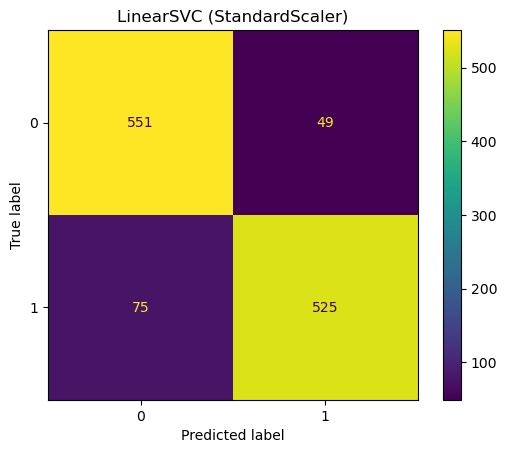



LinearSVC (StandardScaler)


TP: 525 FP: 49 TN: 551 FN: 75
Accuracy: 0.897
Built-in function F1: 0.894
Manually calculated F1: 0.894


              precision    recall  f1-score   support

      normal       0.88      0.92      0.90       600
    abnormal       0.91      0.88      0.89       600

    accuracy                           0.90      1200
   macro avg       0.90      0.90      0.90      1200
weighted avg       0.90      0.90      0.90      1200

Final Accuracy:  0.8966666666666666


In [10]:
print(bestSVC.best_params_)
Y_pred = bestSVC.predict(X_test)
eval("LinearSVC (StandardScaler)", Y_test, Y_pred)
accuracy = bestSVC.score(X_test, Y_test)
print("Final Accuracy: ", accuracy)

<h1>Part 8: Predicting Test Set</h1>

In [11]:
Y_final = bestSVC.predict(testDataBinary)
Y_final = pd.DataFrame(Y_final, columns=['Final Prediction'])

In [12]:
Y_final.value_counts()

Final Prediction
1                   57
0                   43
dtype: int64

<h1>Part 9: Exporting to .csv File</h1>

In [13]:
Y_final.to_csv('results_csv/A12.csv', index=False)